# Introduction to Python for genetic networks

(c) 2017 Justin Bois. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

*This tutorial was generated from a Jupyter notebook.  You can download the notebook [here](intro_to_python_for_systems_biology.ipynb).*

You have already installed [Anaconda](https://store.continuum.io/cshop/anaconda/).  Anaconda contains most of what we need to do scientific computing with Python.  At the most basic level, it has Python 3.6.  It contains other modules we will make heavy use of, the three most important ones being [NumPy](http://www.numpy.org/), [SciPy](http://www.scipy.org/), and [matplotlib](http://matplotlib.org/).

In this tutorial, we will first learn some of the basics of using Python to analyze genetic networks.

We will perform our analysis in a Jupyter notebook.  Jupyter notebooks are great for creating tutorials such as this one.  The beauty of using an Jupyter notebook is that you can combine professional typesetting with individual sections of code.  The code can be run section by section, or the whole document can be run at once.  You will probably want to use a Jupyter notebook for your homework, and this is what we will use interactively during when going over computational techniques in lecture.

To launch a Jupyter notebook, enter

    jupyter notebook

on the command line and hit enter. Jupyter will launch in a browser window.  To the upper right, you can use a pulldown menu to create a new Python 3 Jupyter notebook.  This will open a new tab or window with a fresh notebook.

## Our model system

For the purposes of this tutorial, we will model a cascade.  The genetic network is shown below.

\begin{align}
\mathrm{X} \to \mathrm{Y} \to \mathrm{Z}
\end{align}

Here, X is our input, which we will specify.  We are interested in the response of Y and Z as a function of input X.

We will assume Hill-like behavior for the activation of Y by X and of Z by Y.  We also neglect leakage.  We define the concentrations of X, Y, and Z, respectively as $x$, $y$, and $z$.  The system of ODEs describing this system is then

\begin{align}
\frac{\mathrm{d}y}{\mathrm{d}t} &= \beta_y\,\frac{(x/k_x)^{n_x}}{1+(x/k_x)^{n_x}} - \gamma_y y, \\[2mm]
\frac{\mathrm{d}z}{\mathrm{d}t} &= \beta_z\,\frac{(y/k_y)^{n_y}}{1+(y/k_y)^{n_y}} - \gamma_z z.
\end{align}

Note that $x$ is a function of time.  As is generally a good idea for analysis of these systems, we will non-dimensionalize.  We define dimensionless parameters as follows.

\begin{align}
\tilde{t} &= \gamma_y t, \\[2mm]
\tilde{x} &= x/k_x, \\[2mm]
\tilde{y} &= y/k_y, \\[2mm]
\tilde{z} &= z/k_y, \\[2mm]
\gamma &= \gamma_z/\gamma_y, \\[2mm]
\tilde{\beta}_y &= \frac{\beta_y}{\gamma_y k_y}, \\[2mm]
\tilde{\beta}_z &= \frac{\beta_z}{\gamma_z k_y}.
\end{align}

With these in hand, our dimensionless ODEs are

\begin{align}
\frac{\mathrm{d}\tilde{y}}{\mathrm{d}\tilde{t}} &= \tilde{\beta}_y\,\frac{\tilde{x}^{n_x}}{1+\tilde{x}^{n_x}} - \tilde{y}, \\[2mm]
\gamma^{-1}\,\frac{\mathrm{d}\tilde{z}}{\mathrm{d}\tilde{t}} &= \tilde{\beta}_z\,\frac{\tilde{y}^{n_y}}{1+\tilde{y}^{n_y}} - \tilde{z}.
\end{align}

For notational convenience, and since we will always be working in dimensionless units, we will drop the tildes.

\begin{align}
\frac{\mathrm{d}y}{\mathrm{d}t} &= \beta_y\,\frac{x^{n_x}}{1+x^{n_x}} - y, \\[2mm]
\gamma^{-1}\,\frac{\mathrm{d}z}{\mathrm{d}t} &= \beta_z\,\frac{y^{n_y}}{1+y^{n_y}} - z.
\end{align}

Thus, in addition to the specifics of our input $x(t)$, we have five parameters, $\beta_y$, $\beta_z$, $\gamma$, $n_x$, and $n_y$.

Our goal is to solve this system of ODEs for given parameters and $x(t)$.  We will use `scipy.integrate.odeint()` to do the solutions.

## Modules

In order to do scientific computing and plotting, we need to import the modules that contain the packages we need.  I will go ahead and import all modules we will need for this tutorial now.  I'll talk about each module as we use them throughout the tutorial.

In [6]:
# NumPy and odeint, our workhorses
import numpy as np
import scipy.integrate

# Plotting modules
import matplotlib.pyplot as plt
import seaborn as sns

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables high res graphics inline
%config InlineBackend.figure_formats = {'png', 'retina'}

## scipy.integrate.odeint()

We will use `scipy.integrate.odeint()` to perform the integration of the system of ODEs.  It uses the Hindmarsh algorithm, intelligently dealing with potential stiffness in the equations.

You can look at the documentation for `scipy.integrate.odeint()` [here](http://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html) or you can enter

`scipy.integrate.odeint?`

in a code cell of your Jupyter notebook.  The typical function call to `scipy.integrate.odeint()` that we will use in this class is of the form

    scipy.integrate.odeint(f, y0, t, args=())

`scipy.integrate.odeint()` solves the system of ODEs

\begin{align}
\frac{\mathrm{d}\mathbf{y}}{\mathrm{d}t} = f(\mathbf{y}, t),
\end{align}

where $\mathbf{y}$ is a vector and $f(\mathbf{y},t)$ is vector-valued.  Thus, `scipy.integrate.odeint()` takes as its first argument a function that returns an array containing the right hand side of the system of ODEs you are computing.  When you define this function, it must be of the form

    f(y, t, *args)

where the `*args` indicates the parameters on which the function depends.

The second argument to `scipy.integrate.odeint()` is the initial condition, again stored as an array.  The third argument is an array of time points for which you want the solution to the ODEs.  Finally, as I already mentioned, `args` is a tuple containing the other parameters to be passed into the function `f`.

All this is best seen by example, so we will solve our cascade circuit.

## Solving for a constant input X

For our first foray into using `scipy.integrate.odeint()` to solve ODEs, let's consider the case where we have no X, Y, or Z present.  At time $t = 0$, we suddenly have a concentration of X of $x_0$.  So, we need six parameters for the right hand side of our ODEs, $\beta_y$, $\beta_z$, $\gamma$, $n_x$, $n_y$, and $x_0$.

We now define the function for the right hand side of the ODEs.

In [7]:
def cascade_rhs(yz, t, beta_y, beta_z, gamma, n_x, n_y, x):
    """
    Right hand side for cascade X -> Y -> Z.  Return dy/dt and dz/dt.
    """
    # Unpack y and z
    y, z = yz
    
    # Compute dy/dt
    dy_dt = beta_y * x**n_x / (1 + x**n_x) - y
    
    # Compute dz/dt
    dz_dt = gamma * (beta_z * y**n_y / (1 + y**n_y) - z)
    
    # Return the result as a NumPy array
    return np.array([dy_dt, dz_dt])

We can now define the initial conditions, our parameters, and the time points we want and use `scipy.integrate.odeint()` to solve.

In [8]:
# Time points we want for the solution
t = np.linspace(0, 10, 1000)

# Initial condition
yz_0 = np.array([0.0, 0.0])

# Parameters
beta_y = 1.0
beta_z = 1.0
gamma = 1.0
n_x = 2
n_y = 2
x_0 = 2.0

# Package parameters into a tuple
args = (beta_y, beta_z, gamma, n_x, n_y, x_0)

# Integrate ODES
yz = scipy.integrate.odeint(cascade_rhs, yz_0, t, args=args)

That's it!  The integration is done.  We can now look at what `scipy.integrate.odeint()`'s output looks like.

In [9]:
yz.shape

(1000, 2)

The first column of the output `yz` gives $y(t)$ at the specified time points and the second column gives $z(t)$.  We would now like to plot the results.

## Plotting results

We will use `matplotlib` to plot the results.  The syntax is pretty self-explanatory from the example.  Note the syntax for saving the figure as a PDF, which might be helpful for incorporating your plots into your homeworks.

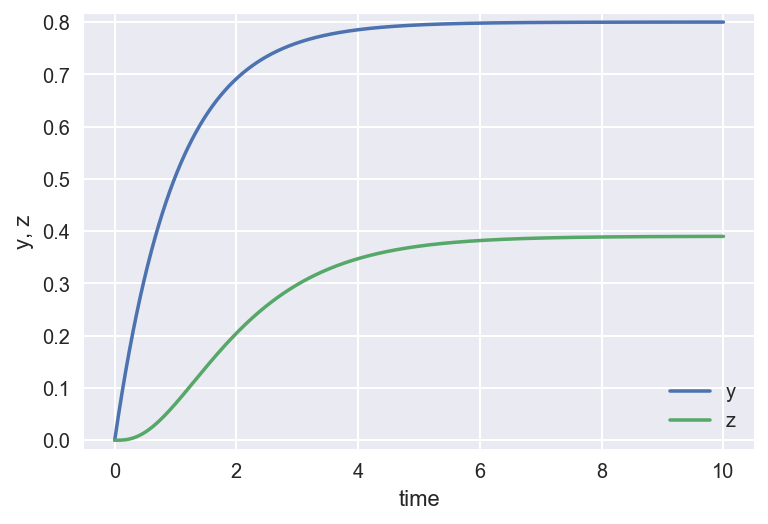

In [10]:
# Pluck out y and z
y, z = yz.transpose()

# Plot the results
plt.plot(t, y)
plt.plot(t, z)

# Make a little space on the margin of the plot
plt.margins(y=0.02)

# Label the axes and make the legend
plt.xlabel('time')
plt.ylabel('y, z')
plt.legend(('y', 'z'), loc='lower right')

# Save the figure
plt.savefig('cascade_constant_x.pdf', bbox_inches='tight')

We see that the casacade acts as a delay for changes in $z$ as a result of input $x$.  With our tools in hand, we can vary parameters and investigate other behavior.

## Cooperativity and strength of repression

When Y strongly and cooperatively activates Z, the delay is longer.  Strong activation means $\beta_z$ is large (since $k_y$ is small), and strong cooperativity means $n_y$ is large.

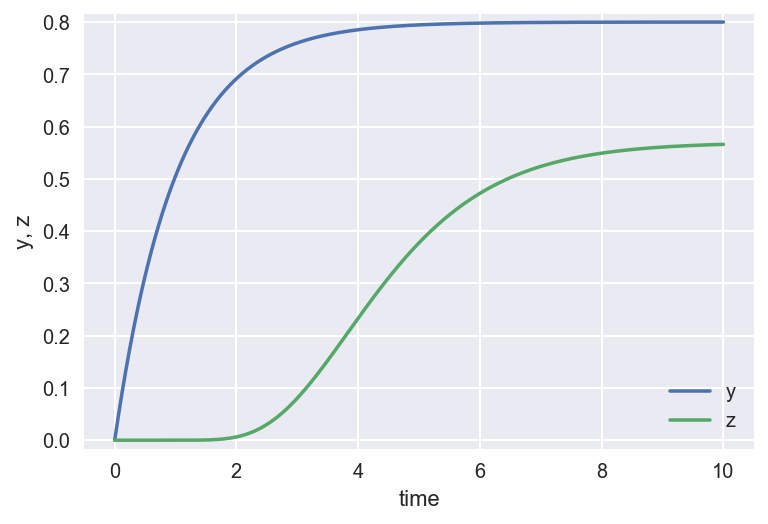

In [11]:
# Parameters
beta_y = 1.0
beta_z = 50.0  # Stronger activation -> higher dimensionless beta
gamma = 1.0
n_x = 2
n_y = 20  # response to Y is much sharper
x_0 = 2.0

# Package parameters into a tuple
args = (beta_y, beta_z, gamma, n_x, n_y, x_0)

# Integrate ODES
yz = scipy.integrate.odeint(cascade_rhs, yz_0, t, args=args)

# Pluck out y and z
y, z = yz.transpose()

# Plot the results
plt.plot(t, y)
plt.plot(t, z)

# Make a little space on the margin of the plot
plt.margins(y=0.02)

# Label the axes and make the legend
plt.xlabel('time')
plt.ylabel('y, z')
plt.legend(('y', 'z'), loc='lower right');

## Amplitude of input

We'll now see what happens when we change the strength of the input signal.  We'll vary $x_0$ from $10^{-2}$ to $10^{2}$.  We will also use subplots to show how we can make plots side-by-side.  We will continue to use the strong, cooperative activation parameters.

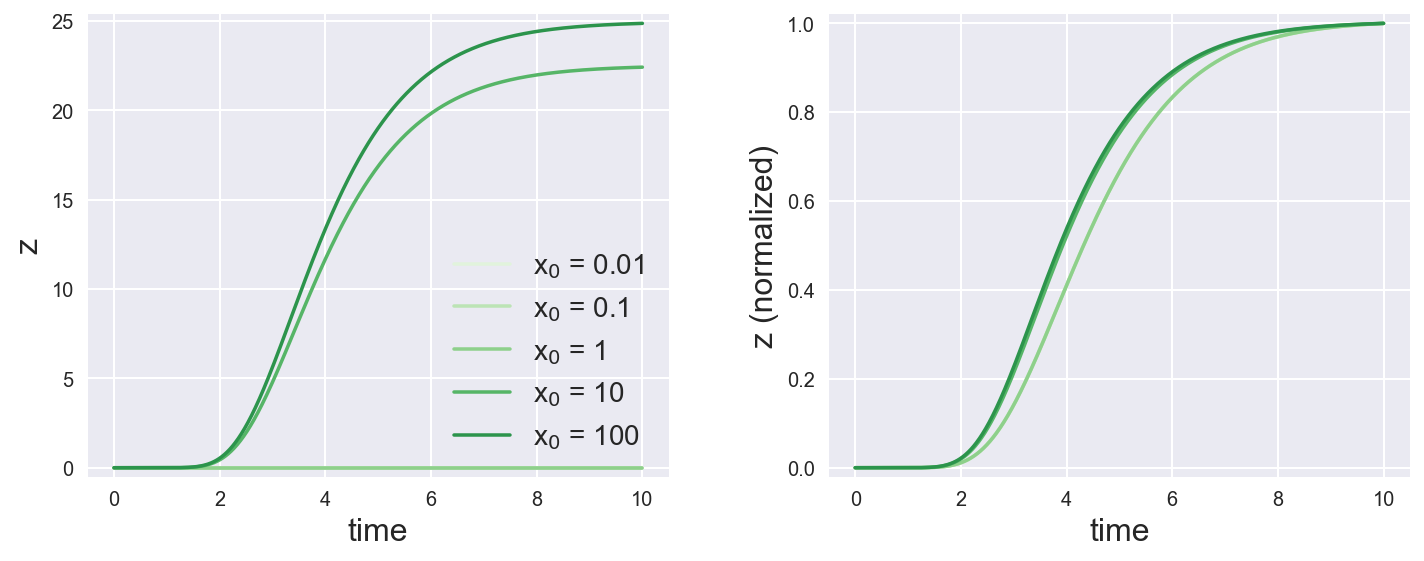

In [12]:
# Parameter values
beta_y = 1.0
beta_z = 50.0
gamma = 1.0
n_x = 2
n_y = 20

# Value of x_0 to consider
x_0 = np.array([0.01, 0.1, 1, 10, 100])

# Set up color scheme
palette = sns.color_palette('Greens')

# List of strings for legend
leg = []

# Set up subplots
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Integrate ODEs and make plots
for i in range(len(x_0)):
    # Make args with new x_0
    args = (beta_y, beta_z, gamma, n_x, n_y, x_0[i])

    # Solve ODEs and extract result
    yz = scipy.integrate.odeint(cascade_rhs, yz_0, t, args=args)
    y, z = yz.transpose()
    
    # Plot results, unnormalized and normalized
    ax[0].plot(t, z, '-', color=palette[i])
    ax[1].plot(t, z/z.max(), '-', color=palette[i])
        
    # Store the legend string
    leg.append('x$_0$ = %g' % x_0[i])

# Tidy up the plot
ax[0].margins(y=0.02)
ax[0].set_xlabel('time', fontsize=16)
ax[0].set_ylabel('z', fontsize=16)
ax[1].margins(y=0.02)
ax[1].set_xlabel('time', fontsize=16)
ax[1].set_ylabel('z (normalized)', fontsize=16)
ax[0].legend(leg, loc='lower right', fontsize=14)

# Make a nice layout
plt.tight_layout(w_pad=4)

# Save the figure
plt.savefig('varying_x0.pdf', bbox_inches='tight')

We see that the time of the response in $z$ is independent of $x_0$, and once $x_0$ his high enough to saturate the $y$ response, the amplitude of the $z$ response also saturates.

## Duration of input

Now imagine that the input is a pulse of duration $\tau$.  We can write a function for this and plot it.

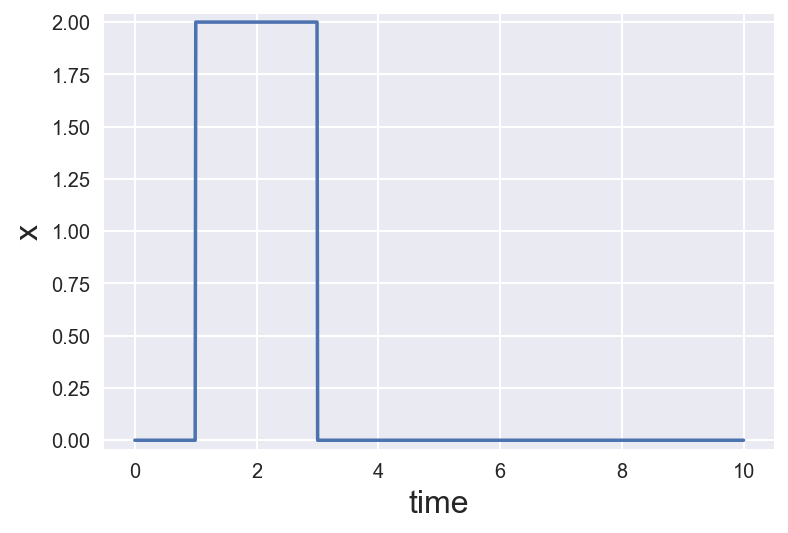

In [13]:
def x_pulse(t, t_0, tau, x_0):
    """
    Returns x value for a pulse beginning at t = 0 
    and ending at t = t_0 + tau.
    """
    return np.logical_and(t >= t_0, t <= (t_0 + tau)) * x_0

# Plot the pulse
plt.plot(t, x_pulse(t, 1.0, 2.0, 2))
plt.xlabel('time', fontsize=16)
plt.ylabel('x', fontsize=16)
plt.margins(y=0.02)

If we want to solve the ODEs for a pulsed input, we need to have a way to pass this function as a parameter.  Fortunately, we can pass functions as arguments in Python!  So, we write a new function that takes `x_fun`, the function describing $x(t)$ as an argument, as well as `x_args`, the set of parameters passed into `x_fun`.

In [14]:
def cascade_rhs_x_fun(yz, t, beta_y, beta_z, gamma, n_x, n_y, x_fun, x_args):
    """
    Right hand side for cascade X -> Y -> Z.  Return dy/dt and dz/dt.
    
    x_fun is a function of the form x_fun(t, *x_args), so x_args is a tuple
    containing the arguments to pass to x_fun.
    """
    # Compute x
    x = x_fun(t, *x_args)
    
    # Return cascade RHS with this value of x
    return cascade_rhs(yz, t, beta_y, beta_z, gamma, n_x, n_y, x)

With this in hand, we can now solve for a pulse.  We will have a pulse during $1 \le t \le 5$.

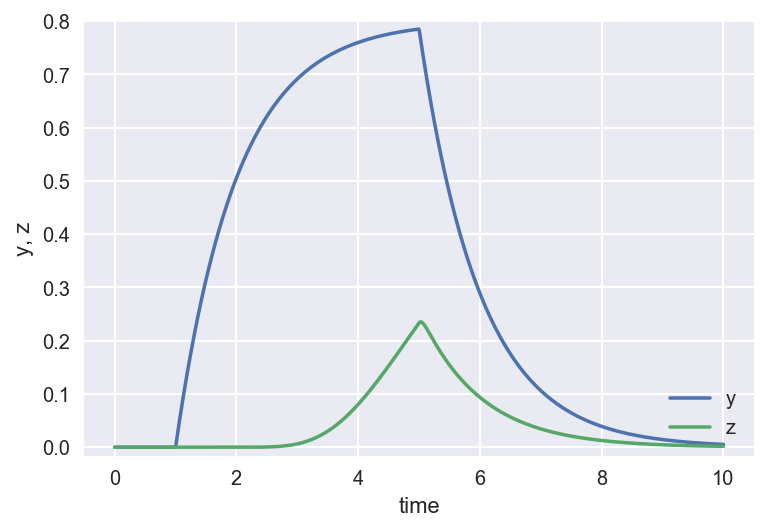

In [15]:
# Set up parameters for the pulse (on at t = 1, off at t = 5, x_0 = 2)
x_args = (1.0, 4.0, 2.0)

# Package parameters into a tuple
args = (beta_y, beta_z, gamma, n_x, n_y, x_pulse, x_args)

# Integrate ODEs
yz = scipy.integrate.odeint(cascade_rhs_x_fun, yz_0, t, args=args)

# Pluck out y and z
y, z = yz.transpose()

# Plot the results
plt.plot(t, y)
plt.plot(t, z)

# Make a little space on the margin of the plot
plt.margins(y=0.02)

# Label the axes and make the legend
plt.xlabel('time')
plt.ylabel('y, z')
plt.legend(('y', 'z'), loc='lower right');

Let's see what happens when we do a shorter pulse, this time with $1 \le t \le 3$.

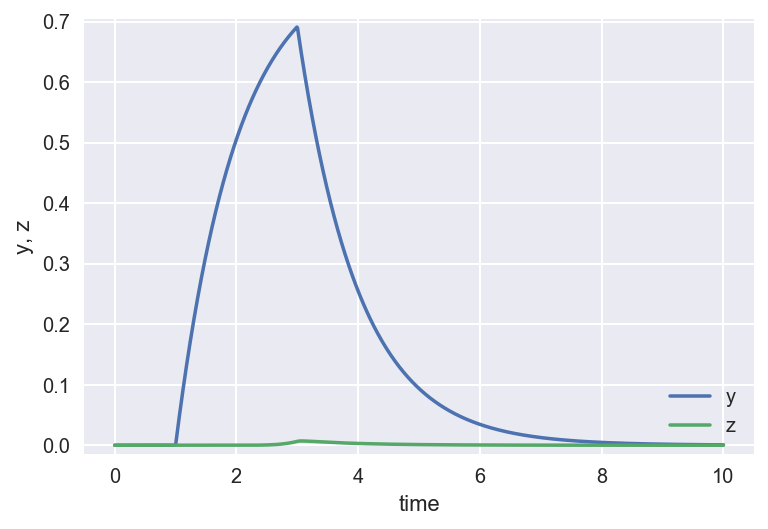

In [16]:
# Set up parameters for the pulse (on at t = 1, off at t = 3, x_0 = 2)
x_args = (1.0, 2.0, 2.0)

# Package parameters into a tuple
args = (beta_y, beta_z, gamma, n_x, n_y, x_pulse, x_args)

# Integrate ODEs
yz = scipy.integrate.odeint(cascade_rhs_x_fun, yz_0, t, args=args)

# Pluck out y and z
y, z = yz.transpose()

# Plot the results
plt.plot(t, y)
plt.plot(t, z)

# Make a little space on the margin of the plot
plt.margins(y=0.02)

# Label the axes and make the legend
plt.xlabel('time')
plt.ylabel('y, z')
plt.legend(('y', 'z'), loc='lower right');

We see that Z basically does not respond to a short pulse.  The delay of the circuit allows short pulses to be ignored, but large pulses to be detected and responded to.

## Really short pulses and a lesson about scipy.integrate.odeint()

Now, we will take a brief interlude to learn an important lesson about the algorithm of `scipy.integrate.odeint()` and its use in these applications.  We will consider a very brief pulse, $1 \le t \le 1.1$.

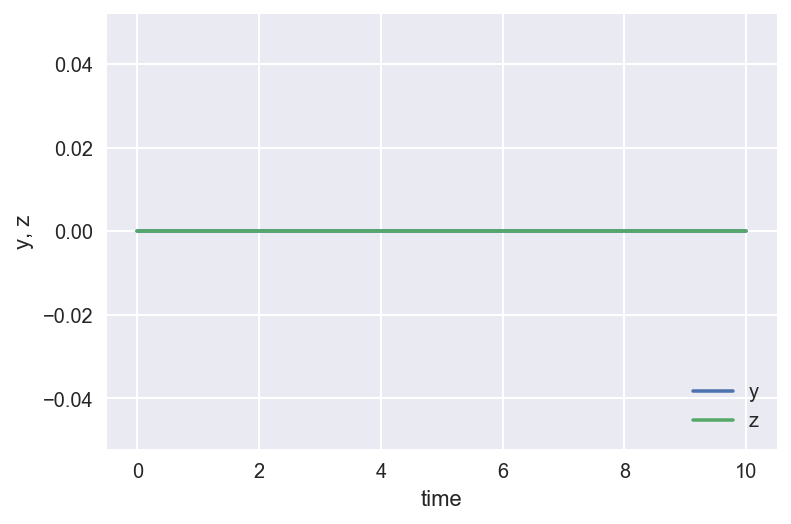

In [17]:
# Set up parameters for the pulse (on at t = 1, off at t = 1.1, x_0 = 2)
x_args = (1.0, 0.1, 2.0)

# Package parameters into a tuple
args = (beta_y, beta_z, gamma, n_x, n_y, x_pulse, x_args)

# Integrate ODEs
yz = scipy.integrate.odeint(cascade_rhs_x_fun, yz_0, t, args=args)

# Pluck out y and z
y, z = yz.transpose()

# Plot the results
plt.plot(t, y)
plt.plot(t, z)

# Make a little space on the margin of the plot
plt.margins(y=0.02)

# Label the axes and make the legend
plt.xlabel('time')
plt.ylabel('y, z')
plt.legend(('y', 'z'), loc='lower right');

Uh oh!  Something went wrong, since the Y signal never went up.  This exposes an important issue with the algorithm used by `scipy.integrate.odeint()`.  The Hindmarsh algorithm uses variable step sizes so that it takes long steps when the system is not changing much and short steps when it is.  Therefore, if we have a long period of no changes (leading up to $t = 1$), the step sizes taken by the solver will increase, and we'll step right over the pulse.

So, it is in general good practice to explicitly take into account discontinuities in the parameters over time.  In this case, we would use `scipy.integrate.odeint()` to integrate to the pulse and use the end point of that as the initial condition of a new solution during the pulse.  Then, at the end of the pulse, we start again.  Let's try again using this method.

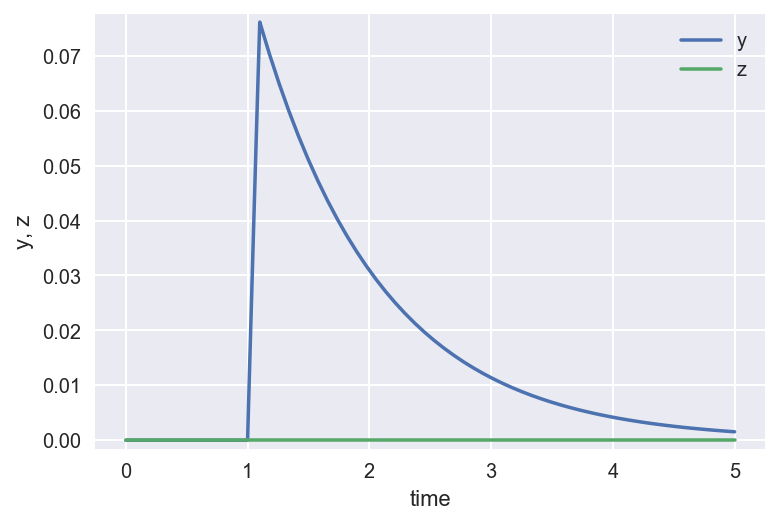

In [18]:
# Integrate prior to pulse
t_before_pulse = np.linspace(0, 1.0, 20)
args = (beta_y, beta_z, gamma, n_x, n_y, 0.0)
yz_0 = np.array([0.0, 0.0])
yz_before_pulse = scipy.integrate.odeint(
                    cascade_rhs, yz_0, t_before_pulse, args=args)

# Integrate during pulse
t_during_pulse = np.linspace(1.0, 1.1, 50)
args = (beta_y, beta_z, gamma, n_x, n_y, 2.0)
yz_0 = yz_before_pulse[-1]
yz_during_pulse = scipy.integrate.odeint(
                    cascade_rhs, yz_0, t_during_pulse, args=args)

# Integrate after pulse
t_after_pulse = np.linspace(1.1, 5, 50)
args = (beta_y, beta_z, gamma, n_x, n_y, 0.0)
yz_0 = yz_during_pulse[-1]
yz_after_pulse = scipy.integrate.odeint(cascade_rhs, yz_0, t_after_pulse, args=args)

# Piece together solution
t = np.concatenate((t_before_pulse, t_during_pulse[1:], t_after_pulse[1:]))
yz = np.vstack((yz_before_pulse, yz_during_pulse[1:,:], 
                yz_after_pulse[1:,:]))
y, z = yz.transpose()

# Plot the results
plt.plot(t, y)
plt.plot(t, z)

# Make a little space on the margin of the plot
plt.margins(y=0.02)

# Label the axes and make the legend
plt.xlabel('time')
plt.ylabel('y, z')
plt.legend(('y', 'z'), loc='upper right');

Much better.  We can write functions to automate this, but we will leave it at this for now with the point made about discontinuities.

## Periodic input

Finally, we will consider the case where we have periodic forcing of the circuit.  We write a function for `x_fun` in which it is periodic with frequency $f$.

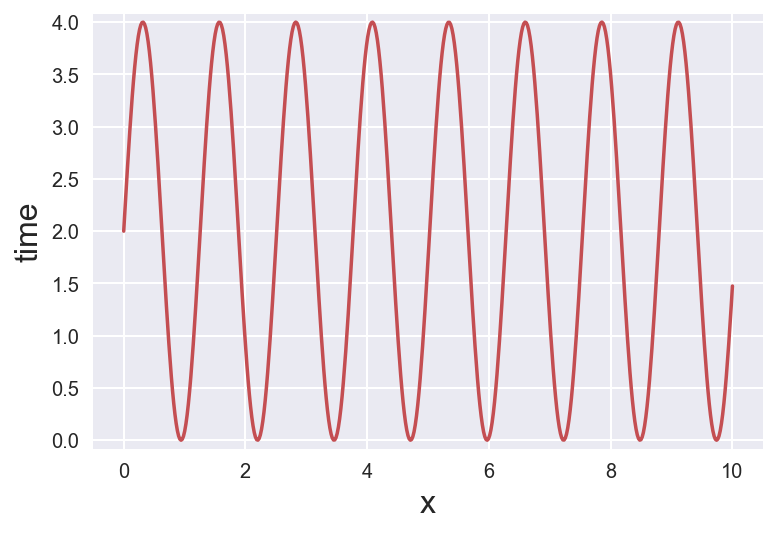

In [19]:
def x_periodic(t, f, x_0):
    """
    Returns x value for periodic forcing of amplitude x_0 and frequency f.
    """
    return x_0 * (1 + np.sin(f * t))

# Plot the forcing
t = np.linspace(0, 10, 500)
plt.plot(t, x_periodic(t, 5, 2.0), color=sns.color_palette()[2])
plt.ylabel('time', fontsize=16)
plt.xlabel('x', fontsize=16)
plt.margins(y=0.02)

Let's see how the circuit responds to a low-frequency input.

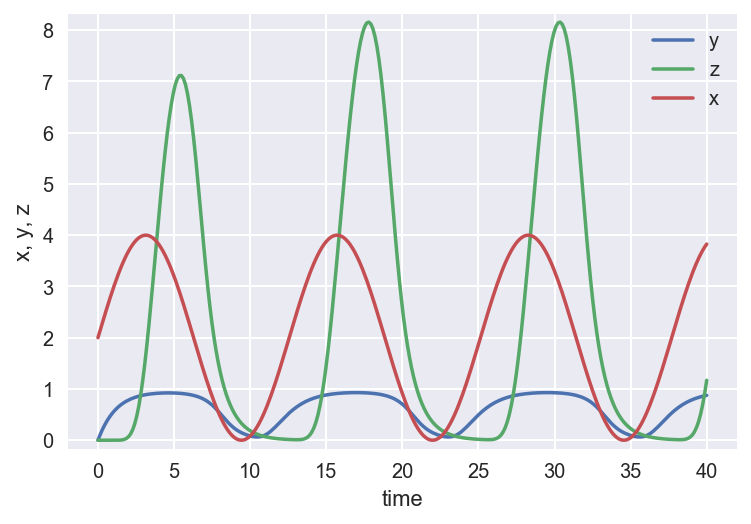

In [20]:
# Set up parameters for periodic forcing with f = 0.5 and x_0 = 2.
x_args = (0.5, 2.0)

# Package parameters into a tuple
args = (beta_y, beta_z, gamma, n_x, n_y, x_periodic, x_args)

# Time points
t = np.linspace(0, 40, 300)

# Initial condition
yz_0 = np.array([0.0, 0.0])

# Integrate ODES
yz = scipy.integrate.odeint(cascade_rhs_x_fun, yz_0, t, args=args)

# Pluck out y and z
y, z = yz.transpose()

# Plot the results
plt.plot(t, y)
plt.plot(t, z)
plt.plot(t, x_periodic(t, *x_args))

# Make a little space on the margin of the plot
plt.margins(y=0.02)

# Label the axes and make the legend
plt.xlabel('time')
plt.ylabel('x, y, z')
plt.legend(('y', 'z', 'x'), loc='upper right');

We roughly follow the forcing with some lag.  Now, for high-frequency forcing, we have a different response.

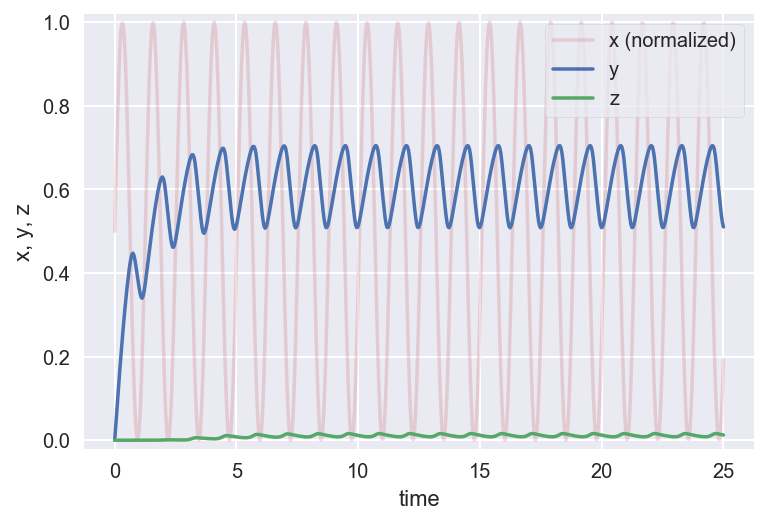

In [21]:
# Set up parameters for periodic forcing with f = 5 and x_0 = 2.
x_args = (5.0, 2.0)

# Package parameters into a tuple
args = (beta_y, beta_z, gamma, n_x, n_y, x_periodic, x_args)

# Time points
t = np.linspace(0, 25, 600)

# Initial condition
yz_0 = np.array([0.0, 0.0])

# Integrate ODES
yz = scipy.integrate.odeint(cascade_rhs_x_fun, yz_0, t, args=args)

# Pluck out y and z
y, z = yz.transpose()

# Plot the results
x = x_periodic(t, *x_args)
x_color = sns.color_palette()[2] + (0.2,)
plt.plot(t, x/x.max(), color=x_color)
plt.plot(t, y)
plt.plot(t, z)

# Make a little space on the margin of the plot
plt.margins(y=0.02)

# Label the axes and make the legend
plt.xlabel('time')
plt.ylabel('x, y, z')
plt.legend(('x (normalized)', 'y', 'z'), loc='best', frameon=True);

We see that Z does not really respond to high frequency forcing, even though the forcing is with the same amplitude.